In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from keras import metrics
from keras.optimizers import SGD, Adam
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.layers.core import Dense,Activation,Dropout

Using TensorFlow backend.


In [2]:
#!pip install pydrive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd 
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bank-full.csv', delimiter=';')



In [7]:
train = train.drop(['duration','day','month'], axis = 1)

In [8]:
train['y'] = train['y'].map({'yes':1, 'no':0})

In [9]:
def impute_age(data):
    if (data['age'] < 18):
        return 'Child'
    elif((data['age'] < 35) & (data['age'] >= 18)):
        return 'Adult'
    elif((data['age'] < 60)) & (data['age'] >= 35):
        return 'Middle-Aged'
    else:
        return 'Old'

In [10]:
train['age'] = train.apply(impute_age , axis = 1)

In [11]:
#we can combine similar jobs into categories
train['job'] = train['job'].replace(['management', 'admin.'], 'admin/manag')
train['job'] = train['job'].replace(['services','housemaid'], 'home/service')
train['job'] = train['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'unemployed')

In [12]:
# combine other and unknown category into failure because only success and failure matters
train['poutcome'] = train['poutcome'].replace(['other'] , 'failure')
train['poutcome'] = train['poutcome'].replace(['unknown'] , 'failure')
train.poutcome.value_counts()

failure    43700
success     1511
Name: poutcome, dtype: int64

In [13]:
train['default'] = train['default'].map( {'yes':1, 'no':0} )
train['default'].value_counts()
train['poutcome'] = train['poutcome'].map( {'success':1, 'failure':0} )

In [14]:
train['housing']=train['housing'].map({'yes':1, 'no':0})
train["loan"] = train['loan'].map({'yes':1, 'no':0})
train['housing'].value_counts()


1    25130
0    20081
Name: housing, dtype: int64

In [15]:
Bal_fil = train.balance<80000
train = train[Bal_fil]

In [16]:
cam_fil = train.campaign<50
train = train[cam_fil]

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def encode_and_bind(orignal_dataframe , feature_to_encode):
    dummies = pd.get_dummies(orignal_dataframe[[feature_to_encode]])
    res = pd.concat([orignal_dataframe , dummies] , axis = 1)
    return res

for i in [col for col, dtype in train.dtypes.items() if dtype == 'object']:
    if i in ['age','job','marital','education','contact']:
        train = encode_and_bind(train, i)

In [18]:
train = train.drop(['age','job','marital','education','contact'], axis = 1)

In [19]:
predictors = train.drop('y', axis = 1)
to_predict = train['y']

In [20]:
predictors.shape

(45201, 28)

In [21]:
predictors.head()

,default,balance,housing,loan,campaign,pdays,previous,poutcome,age_Adult,age_Middle-Aged,age_Old,job_admin/manag,job_blue-collar,job_entrepreneur,job_home/service,job_self-employed,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown
0,0,2143,1,0,1,-1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
1,0,29,1,0,1,-1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,0,2,1,1,1,-1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
3,0,1506,1,0,1,-1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
4,0,1,0,0,1,-1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1


In [22]:
train_data , test_data,train_targets, test_targets = train_test_split(predictors , to_predict , test_size = 0.2 , random_state = 40)

In [23]:
train_data.shape

(36160, 28)

Normalize the data

In [24]:
mean = train_data.mean(axis = 0)
train_data = train_data - mean
std = train_data.std(axis = 0)
train_data = train_data/std 


In [25]:
#same we have to do with test data  too

test_data = test_data - mean
test_data = test_data / std

In [26]:
print((train_data.shape[1],))

(28,)


In [27]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36160 entries, 16799 to 11594
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   default              36160 non-null  float64
 1   balance              36160 non-null  float64
 2   housing              36160 non-null  float64
 3   loan                 36160 non-null  float64
 4   campaign             36160 non-null  float64
 5   pdays                36160 non-null  float64
 6   previous             36160 non-null  float64
 7   poutcome             36160 non-null  float64
 8   age_Adult            36160 non-null  float64
 9   age_Middle-Aged      36160 non-null  float64
 10  age_Old              36160 non-null  float64
 11  job_admin/manag      36160 non-null  float64
 12  job_blue-collar      36160 non-null  float64
 13  job_entrepreneur     36160 non-null  float64
 14  job_home/service     36160 non-null  float64
 15  job_self-employed    36160 non-n

In [28]:
train_targets

16799    0
12178    0
22868    0
15126    0
41513    0
        ..
11536    0
27647    0
14506    0
30734    0
11594    0
Name: y, Length: 36160, dtype: int64

very few samples are available, you’ll use a very small network with two hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting

In [29]:
import tensorflow as tf
from tensorflow import keras
np.random.seed(1671)  #for Reproducibility

#network and training
EPOCH = 20
BATCH_SIZE = 128
VERBOSE = 1 
OPTIMIZER= SGD(learning_rate=0.001, momentum=0.9)   #Gradient Descent Optimizer
VALIDATION_SPLIT = 0.2 #Splitting the data in validation and train and form the main subset of train data

In [30]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

**Usage of initializers**
Initializers define the way to set the initial random weights of Keras layers.

In [55]:
from keras import models
from keras import layers


def build_model(metrics = METRICS,output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
 
  
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_data.shape[1],)),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(8, activation='relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  #Compiling the model

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  return model 

In [56]:
neg, pos = np.bincount(train_targets)
total = neg + pos
initial_bias = np.log([pos/neg])
initial_bias


array([-2.02967001])

In [57]:
model = build_model(output_bias = initial_bias)
#model = build_model()

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [58]:
results = model.evaluate(train_data, train_targets, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3749


In [59]:
#Training the model with actual inputs
from keras.callbacks import EarlyStopping
#callback = EarlyStopping( monitor='loss' , patience=3)
callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
    
)



**Confirm that the bias fix helps**

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses:

In [63]:
model = build_model(output_bias = 0.0)

zero_bias_history = model.fit(train_data , train_targets , batch_size = BATCH_SIZE ,  epochs = EPOCH , verbose=VERBOSE,callbacks = [callback] , validation_split=VALIDATION_SPLIT)

Epoch 1/20
226/226 [==============================] - 1s 6ms/step - loss: 0.5364 - tp: 1019.0000 - fp: 5001.0000 - tn: 26960.0000 - fn: 3180.0000 - accuracy: 0.7738 - precision: 0.1693 - recall: 0.2427 - auc: 0.6024 - val_loss: 0.3402 - val_tp: 78.0000 - val_fp: 55.0000 - val_tn: 6318.0000 - val_fn: 781.0000 - val_accuracy: 0.8844 - val_precision: 0.5865 - val_recall: 0.0908 - val_auc: 0.6840 - lr: 0.0010
Epoch 2/20
226/226 [==============================] - 1s 3ms/step - loss: 0.3471 - tp: 455.0000 - fp: 345.0000 - tn: 25243.0000 - fn: 2885.0000 - accuracy: 0.8883 - precision: 0.5688 - recall: 0.1362 - auc: 0.6873 - val_loss: 0.3230 - val_tp: 111.0000 - val_fp: 59.0000 - val_tn: 6314.0000 - val_fn: 748.0000 - val_accuracy: 0.8884 - val_precision: 0.6529 - val_recall: 0.1292 - val_auc: 0.7219 - lr: 0.0010
Epoch 3/20
226/226 [==============================] - 1s 3ms/step - loss: 0.3342 - tp: 466.0000 - fp: 286.0000 - tn: 25302.0000 - fn: 2874.0000 - accuracy: 0.8908 - precision: 0.6197 

In [64]:
model = build_model(output_bias = initial_bias)
careful_bias_history = model.fit(train_data , train_targets , batch_size = BATCH_SIZE ,  epochs = EPOCH , verbose=VERBOSE,callbacks = [callback] , validation_split=VALIDATION_SPLIT)

Epoch 1/20
226/226 [==============================] - 1s 6ms/step - loss: 0.3413 - tp: 353.0000 - fp: 216.0000 - tn: 31745.0000 - fn: 3846.0000 - accuracy: 0.8877 - precision: 0.6204 - recall: 0.0841 - auc: 0.6611 - val_loss: 0.3236 - val_tp: 107.0000 - val_fp: 38.0000 - val_tn: 6335.0000 - val_fn: 752.0000 - val_accuracy: 0.8908 - val_precision: 0.7379 - val_recall: 0.1246 - val_auc: 0.7114 - lr: 0.0010
Epoch 2/20
226/226 [==============================] - 1s 2ms/step - loss: 0.3182 - tp: 423.0000 - fp: 244.0000 - tn: 25344.0000 - fn: 2917.0000 - accuracy: 0.8907 - precision: 0.6342 - recall: 0.1266 - auc: 0.7127 - val_loss: 0.3185 - val_tp: 125.0000 - val_fp: 48.0000 - val_tn: 6325.0000 - val_fn: 734.0000 - val_accuracy: 0.8919 - val_precision: 0.7225 - val_recall: 0.1455 - val_auc: 0.7301 - lr: 0.0010
Epoch 3/20
226/226 [==============================] - 1s 2ms/step - loss: 0.3143 - tp: 467.0000 - fp: 254.0000 - tn: 25334.0000 - fn: 2873.0000 - accuracy: 0.8919 - precision: 0.6477 -

In [65]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

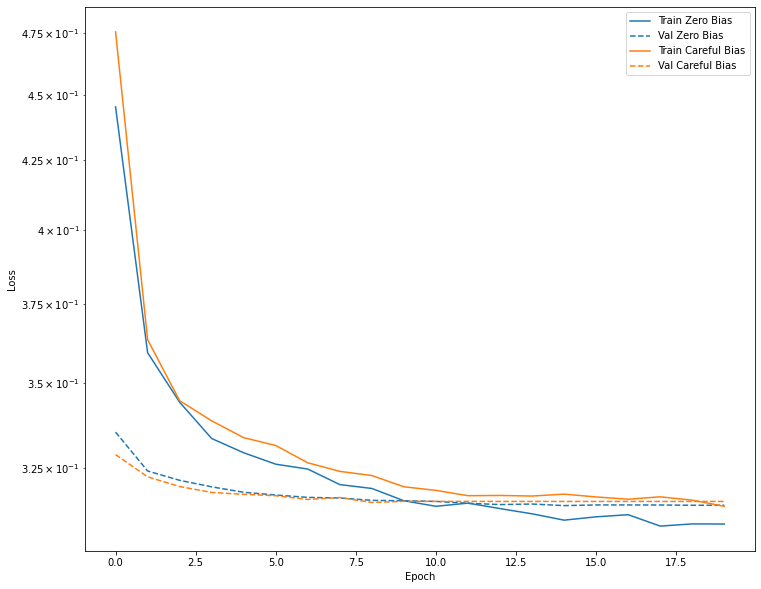

In [40]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a NO clear advantage.

In [68]:
baseline_model = build_model(output_bias = 0.0)

baseline_history = baseline_model.fit(train_data , train_targets , batch_size = BATCH_SIZE ,  epochs = EPOCH , verbose=VERBOSE,callbacks = [callback] , validation_split=VALIDATION_SPLIT)

Epoch 1/20
226/226 [==============================] - 1s 6ms/step - loss: 0.4189 - tp: 417.0000 - fp: 1500.0000 - tn: 30461.0000 - fn: 3782.0000 - accuracy: 0.8539 - precision: 0.2175 - recall: 0.0993 - auc: 0.6148 - val_loss: 0.3352 - val_tp: 36.0000 - val_fp: 10.0000 - val_tn: 6363.0000 - val_fn: 823.0000 - val_accuracy: 0.8848 - val_precision: 0.7826 - val_recall: 0.0419 - val_auc: 0.6906 - lr: 0.0010
Epoch 2/20
226/226 [==============================] - 1s 2ms/step - loss: 0.3327 - tp: 381.0000 - fp: 224.0000 - tn: 25364.0000 - fn: 2959.0000 - accuracy: 0.8900 - precision: 0.6298 - recall: 0.1141 - auc: 0.6991 - val_loss: 0.3233 - val_tp: 135.0000 - val_fp: 58.0000 - val_tn: 6315.0000 - val_fn: 724.0000 - val_accuracy: 0.8919 - val_precision: 0.6995 - val_recall: 0.1572 - val_auc: 0.7153 - lr: 0.0010
Epoch 3/20
226/226 [==============================] - 1s 2ms/step - loss: 0.3250 - tp: 479.0000 - fp: 264.0000 - tn: 25324.0000 - fn: 2861.0000 - accuracy: 0.8920 - precision: 0.6447 -

In [69]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0,1])

    plt.legend()

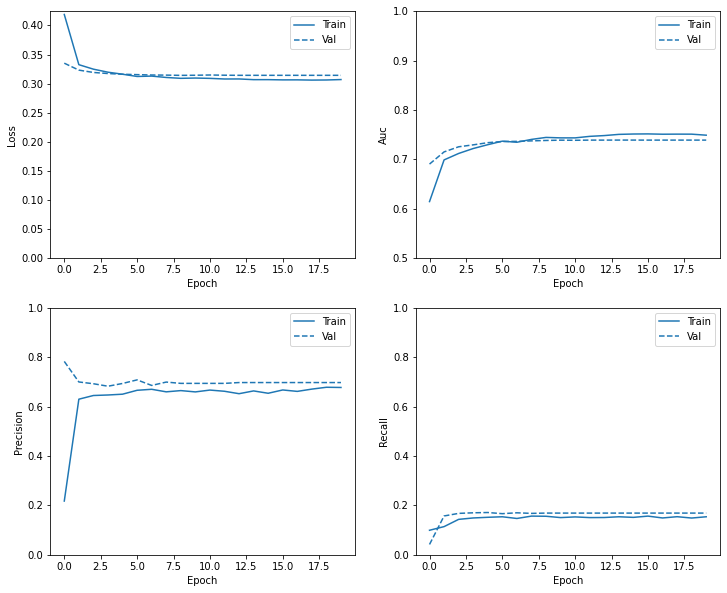

In [70]:
plot_metrics(baseline_history)

loss :  0.31616201996803284
tp :  157.0
fp :  79.0
tn :  7874.0
fn :  931.0
accuracy :  0.8882867097854614
precision :  0.6652542352676392
recall :  0.14430147409439087
auc :  0.7522426247596741

Legitimate Transactions Detected (True Negatives):  7874
Legitimate Transactions Incorrectly Detected (False Positives):  79
Fraudulent Transactions Missed (False Negatives):  931
Fraudulent Transactions Detected (True Positives):  157
Total Fraudulent Transactions:  1088


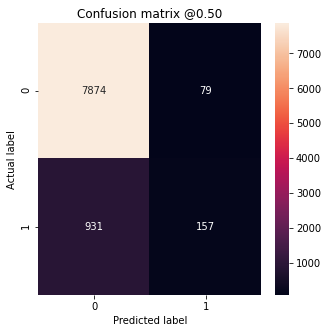

In [71]:

from sklearn.metrics import confusion_matrix

train_predictions_baseline = model.predict(train_data, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_data, batch_size=BATCH_SIZE)

from sklearn import metrics 

def plot_cm(labels, predictions, p=.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Failure Term deposit Detected (True Negatives): ', cm[0][0])
  print('Failure Term deposit Incorrectly Detected (False Positives): ', cm[0][1])
  print('Term deposit Missed (False Negatives): ', cm[1][0])
  print('Term deposit Detected (True Positives): ', cm[1][1])
  print('Total Transactions: ', np.sum(cm[1]))
  


baseline_results = model.evaluate(test_data, test_targets,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_targets, test_predictions_baseline)

## Using Class weights

In [81]:

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.57
Weight for class 1: 4.31


In [82]:
weighted_model = build_model()
weighted_history = weighted_model.fit(train_data , train_targets , batch_size = BATCH_SIZE ,class_weight=class_weight,  epochs = 20 , verbose=VERBOSE,callbacks = [callback] , validation_split=VALIDATION_SPLIT)

Epoch 1/20
226/226 [==============================] - 1s 6ms/step - loss: 0.7425 - tp: 3550.0000 - fp: 20078.0000 - tn: 13463.0000 - fn: 878.0000 - accuracy: 0.4481 - precision: 0.1502 - recall: 0.8017 - auc: 0.6491 - val_loss: 0.6520 - val_tp: 616.0000 - val_fp: 2875.0000 - val_tn: 3498.0000 - val_fn: 243.0000 - val_accuracy: 0.5689 - val_precision: 0.1765 - val_recall: 0.7171 - val_auc: 0.6975 - lr: 0.0010
Epoch 2/20
226/226 [==============================] - 1s 3ms/step - loss: 0.6274 - tp: 2339.0000 - fp: 10661.0000 - tn: 14927.0000 - fn: 1001.0000 - accuracy: 0.5969 - precision: 0.1799 - recall: 0.7003 - auc: 0.7072 - val_loss: 0.6210 - val_tp: 579.0000 - val_fp: 2322.0000 - val_tn: 4051.0000 - val_fn: 280.0000 - val_accuracy: 0.6402 - val_precision: 0.1996 - val_recall: 0.6740 - val_auc: 0.7232 - lr: 0.0010
Epoch 3/20
226/226 [==============================] - 1s 3ms/step - loss: 0.6080 - tp: 2317.0000 - fp: 9663.0000 - tn: 15925.0000 - fn: 1023.0000 - accuracy: 0.6306 - precisio

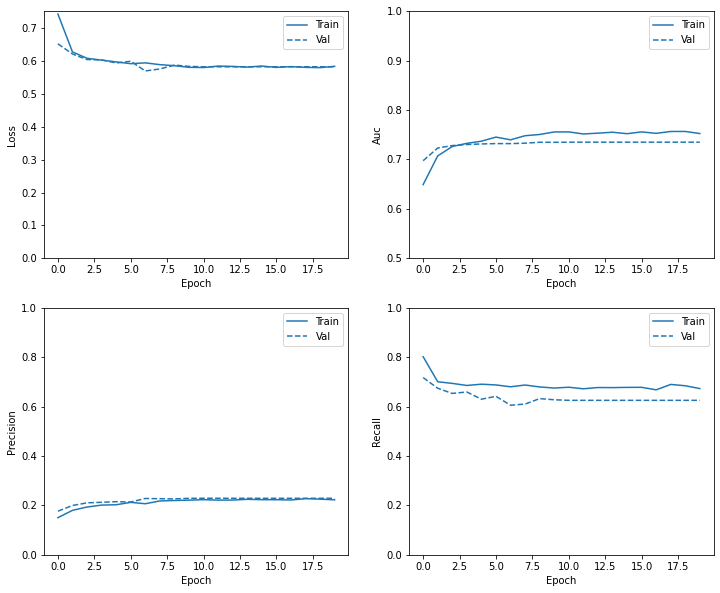

In [83]:
plot_metrics(weighted_history)

loss :  0.5806705355644226
tp :  728.0
fp :  2261.0
tn :  5692.0
fn :  360.0
accuracy :  0.7100984454154968
precision :  0.24355971813201904
recall :  0.6691176295280457
auc :  0.7512601613998413

Legitimate Transactions Detected (True Negatives):  5692
Legitimate Transactions Incorrectly Detected (False Positives):  2261
Fraudulent Transactions Missed (False Negatives):  360
Fraudulent Transactions Detected (True Positives):  728
Total Fraudulent Transactions:  1088


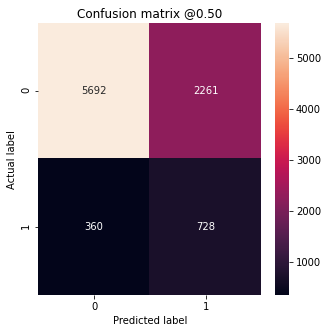

In [84]:

from sklearn.metrics import confusion_matrix

train_predictions_weighted = weighted_model.predict(train_data, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_data, batch_size=BATCH_SIZE)



weighted_results = weighted_model.evaluate(test_data, test_targets,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_targets, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

## Oversampling

Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [85]:
from imblearn.over_sampling import SMOTE


X_resampled, y_resampled = SMOTE().fit_resample(train_data, train_targets)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [50]:
train_data.shape

(36160, 28)

In [51]:
X_resampled.shape

(63922, 28)

In [52]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

500.0

## Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

In [86]:
resampled_model = build_model()


# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

resampled_history = resampled_model.fit(X_resampled , y_resampled , batch_size = BATCH_SIZE ,  epochs = 100 , verbose=VERBOSE,callbacks = [early_stopping] , validation_split=VALIDATION_SPLIT)

Epoch 1/100
400/400 [==============================] - 2s 5ms/step - loss: 0.5868 - tp: 7614.0000 - fp: 5931.0000 - tn: 33983.0000 - fn: 12650.0000 - accuracy: 0.6912 - precision: 0.5621 - recall: 0.3757 - auc: 0.7011 - val_loss: 0.8049 - val_tp: 5094.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 7691.0000 - val_accuracy: 0.3984 - val_precision: 1.0000 - val_recall: 0.3984 - val_auc: 0.0000e+00
Epoch 2/100
400/400 [==============================] - 1s 3ms/step - loss: 0.5601 - tp: 8310.0000 - fp: 3621.0000 - tn: 28340.0000 - fn: 10866.0000 - accuracy: 0.7167 - precision: 0.6965 - recall: 0.4334 - auc: 0.7517 - val_loss: 0.8145 - val_tp: 5583.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 7202.0000 - val_accuracy: 0.4367 - val_precision: 1.0000 - val_recall: 0.4367 - val_auc: 0.0000e+00
Epoch 3/100
400/400 [==============================] - 1s 3ms/step - loss: 0.5530 - tp: 8646.0000 - fp: 3679.0000 - tn: 28282.0000 - fn: 10530.0000 - accuracy: 0.7221 - precision: 0.

loss :  0.4536041021347046
tp :  418.0
fp :  676.0
tn :  7277.0
fn :  670.0
accuracy :  0.8511226773262024
precision :  0.38208410143852234
recall :  0.3841911852359772
auc :  0.7418040037155151

Legitimate Transactions Detected (True Negatives):  7277
Legitimate Transactions Incorrectly Detected (False Positives):  676
Fraudulent Transactions Missed (False Negatives):  670
Fraudulent Transactions Detected (True Positives):  418
Total Fraudulent Transactions:  1088


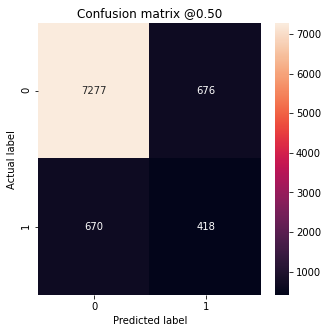

In [87]:

from sklearn.metrics import confusion_matrix


test_predictions_resampled = resampled_model.predict(test_data, batch_size=BATCH_SIZE)



resampled_results = resampled_model.evaluate(test_data, test_targets,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_targets, test_predictions_resampled)